[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aarondomenzain/tracking-softmatter-aarond/blob/tracking-softmatter-aarond-dev/tutorial/detection/detection_ellipses.ipynb)

# Particle tracking tutorial: Detection of particles

This tutorial intends to compare different methods for the detection of particles from image files, both from experimental data and simulations. It relies on a number of Python packages, including NumPy, SciKit, Matplotlib, PyTorch, Deeptrack, Deeplay.

### 1. Import all the necessary libraries

Uncomment the next cell if running on Google Colab/Kaggle.

In [1]:
# !pip install deeplay deeptrack trackpy  -q

Load a set of functions written for this notebook from a utilities file. Thorough documentation of each function is contained in the file.

In [2]:
# Standard libraries.
#import math  # Mathematical operations.
import os  # Operating system dependent functionality.
import random  # Generate random numbers.
import sys  # System-specific parameters and functions.

# External libraries.
#import cv2  # OpenCV (Computer Vision).
import deeptrack as dt  # DeepTrack.
import deeplay as dl  # Deeplay.
from deeptrack.extras.radialcenter import radialcenter as rc 
from itertools import cycle # Iterate over a list.
import imageio  # Creates images/video from data.
import matplotlib # Plotting package
import matplotlib.pyplot as plt  # Plotting package with additional funcitons.
import numpy as np  # Scientific computing using arrays.
import scipy  # Optimized for linear algebra, signal processing.
import skimage  # Image analysis (scikit).
import torch  # PyTorch library for neural network applications.
import trackpy as tp  # Particle tracking package (Crocker & Grier method).

Load a set of functions written for this notebook from a utilities file. Thorough documentation of each function is contained in the file.

In [3]:
# Append the enclosing folder to the system path so that the utilities file can 
# be imported.
sys.path.append("..")

# Import all the functions contained in the utilities file utils.py.
import utils

### 2. Visualization of an experiment
Load a TIF image contained in a folder called images. Visualize the image using SciKit. 

Selected file: images/vi_5.5_f.bmp


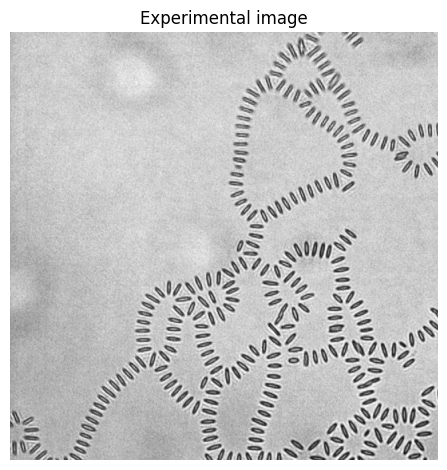

Resolution of imported image in pixels: (640, 640)


In [4]:
# Define the folder and image file name.
image_folder = "images"
image_file_name =  "vi_5.5_f.bmp"

# Construct the full path.
image_path = os.path.join(image_folder, image_file_name)

# Create an instance of the loaded file using SciKit.
image = skimage.io.imread(image_path)

# Crop the image to a square. Some rectangular images may cause issues when 
# using some deep learning methods.
#image = image[:1024, :1024]
image = image[:640, :640]

# Print the name of the selected file.
print("Selected file:", image_path)

# Open a figure instance.
plt.figure()

# Plot the image in grayscale.
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Experimental image")
plt.tight_layout()
plt.show()

# Print the image size in pixels.
print(f"Resolution of imported image in pixels: {image.shape}")

Manually select and display a single object by specifying its coordinates (x,y).

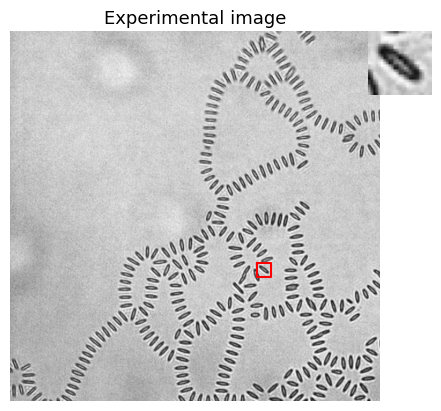

In [5]:
# Window size to zoom in an individual particle.
width = 25 

# Position of the window.
x = 412- width // 2 
y = 439 - width // 2

# Select a crop as a subset of the entire image.
crop = image[x:x + width, y:y + width]

# Initialize figure instance.
fig = plt.figure()

# Draw a red rectangle around the crop.
fig.add_subplot(111)
plt.imshow(image, cmap='gray')
plt.title("Experimental image", size=13)
plt.plot([y, y+width, y+width, y, y], [x, x, x+width, x+width, x], 'r-')
plt.axis('off')

# Plot the rectangle on the top right corner.
fig.add_subplot(555)
plt.imshow(crop, cmap='gray')
plt.axis('off')
plt.show()

### 3. Use DeepTrack to simulate a realistic image to test the performance of different methods. 
DeepTrack can be used to simulate physically realistic scenarios, which can be used to train neural network models.


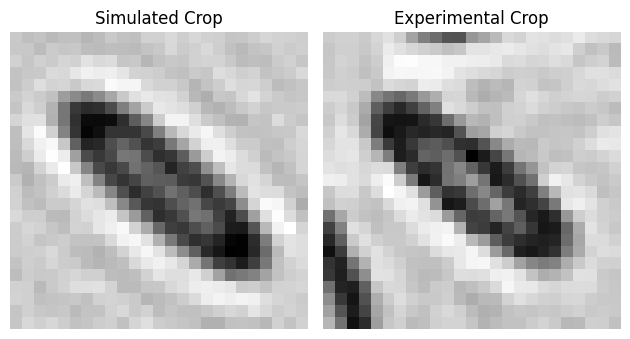

In [6]:
# Same as when selecting a single object.
image_size = width

# Size of the long ellipsoid semiaxis in nm.
axis_length = 1100

# Eccentricity of ellipsoid.
eccentricity = 0.15

# Define ellippsoidal object.
inner_ellipse = dt.Ellipsoid(
    position=0.5 * np.array([image_size, image_size]),
    radius=(axis_length, eccentricity * axis_length)
    * dt.units.nm,  # Radius in nanometers
    intensity=-20,  # Field magnitude squared
    rotation=0.225 * np.pi,
    )

# Define a surrounding shell with a radius of 2.1 times the radius of the spherical core
outer_ellipse = dt.Ellipsoid(
    position = inner_ellipse.position, # Set the same position as the inner sphere
    radius = 1.0 * dt.units.nm * (axis_length, eccentricity * axis_length), #Outer sphere must be bigger than inner sphere
    intensity= -0.1 * inner_ellipse.intensity,
    rotation=inner_ellipse.rotation,
    )

# Instance containing the core + shell spheres
combined_ellipse = inner_ellipse >> outer_ellipse

# Set the optical properties of the microscope.
optics = dt.Darkfield(
    NA=1.33,  # Numerical aperture
    wavelength=638.0 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=2,
    resolution=200 * dt.units.nm,  # Camera resolution or effective resolution.
    )

# Apply transformations: combine ellipsoids, add Gaussian noise and normalize.
sim_crop = (
    optics(combined_ellipse)
    >> dt.Gaussian(0.0, 0.1)
    >> dt.NormalizeMinMax(0.0, 1.0)
    )

# Convert crop into NumPy array.
simulated_crop = np.squeeze(sim_crop()).__abs__() # Ensure real-valued field.

# Plot the simulated and experimental crops.
fig, axes = plt.subplots(1, 2)

# Simulated crop.
plot = axes[0].imshow(simulated_crop, cmap="gray")
axes[0].axis("off")
axes[0].set_title("Simulated Crop")

# Define an ruler bar to measure the particle size in pixel units.
angle = - 0.5
length = 10

# Experimental crop.
axes[1].imshow(crop, cmap="gray")
axes[1].axis("off")
axes[1].set_title("Experimental Crop")

# Adjust layout and show plot.
plt.tight_layout()
plt.show()

### Generate a simulated image to test different detection methods
We generate an image of non-overlapping, ellipsoidal particles. First, their coordinates are generated, which are referred to as ground truth positions. Then, we use DeepTrack to place optically realistic particles on such positions.

In [7]:
# Parameters of the simulation. 
image_size = 256
N_particles = 128
eccentricity = 0.25

# Extract the major axis of the ellipsoidal particle in nm.
particle_radius = axis_length
# Convert to pixlel units (1px = 100nm)
particle_radius_px = particle_radius / 100

# Dictionaries for shell and core properties. Dimensions are set with lambda
# functions to introduce variety to the dataset.
core_particle_properties = {
    "radius": lambda: dt.units.nm * (
        axis_length,
        np.random.uniform(0.95, 1.05) * eccentricity * axis_length
        ),
    "intensity": lambda: -2000 * np.random.uniform(0.95, 1.05),
    }

shell_particle_properties = {
    "radius": lambda: 1.2 * np.random.uniform(1.0, 1.1) * dt.units.nm
    * (axis_length, np.random.uniform(1.0, 1.05) * eccentricity * axis_length),
    "intensity": lambda: 1000 * np.random.uniform(0.95, 1.05),
    }

# Set the optical properties of the microscope.
optics_properties = dt.Darkfield(
    NA=1.33,  # Numerical aperture
    wavelength=638.0 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=2,
    resolution=200 * dt.units.nm,  # Camera resolution or effective resolution.
    )

# Generate ground truth positions.
gt_pos = utils.generate_centroids(
    num_particles=N_particles,
    image_size=image_size,
    particle_radius=particle_radius,
    )

# Simulate image.
simulated_image = utils.transform_to_video(
    gt_pos,
    image_size=image_size,
    core_particle_props=core_particle_properties,
    shell_particle_props=shell_particle_properties,
    optics_props=optics_properties,
    )

# Generate the ground truth as Gaussian clouds centered at the position of the
# ellipsoids. The standard deviation of the Gaussians are proportional to the
# semiaxes of the corresponding particles.
probability_cloud_axis = np.array(
    [axis_length, eccentricity * axis_length]
    ) / 3

# Create the ground truth map using the positions, orientations and size of 
# particles.
simulated_map = utils.create_ground_truth_map(
    gt_pos, 
    image_size=image_size, 
    sigma=probability_cloud_axis
    )

Visualize the simulated image and the corresponding ground truth map. The ground truth of a particle is represented by a Gaussian profile, with a standard deviation in each direction being proportional to the corresponding semiaxes of the ellipsoids. Note that this simulation does not reproduce the oriented structures that elongated colloidal particles usually exhibit, but it is not necessary to simulate this effect for detection purposes.

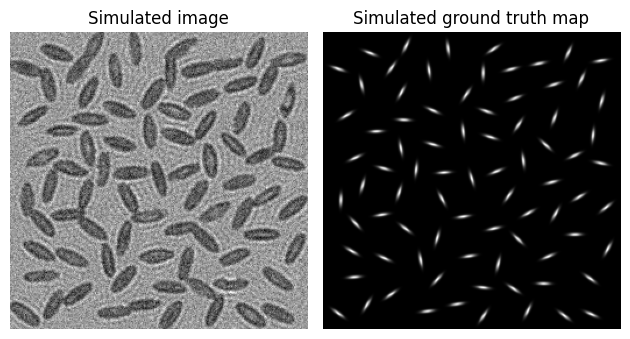

In [8]:
# Create a subfigure instance to plot the image and the ground truth map.
fig, ax = plt.subplots(1, 2)

# Instance for the simulated experimental image. 
img1 = ax[0].imshow(simulated_image, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Simulated image")  # Title for the second subplot.

# Instance for the ground truth map.
img2 = ax[1].imshow(simulated_map, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Simulated ground truth map") 

plt.tight_layout()
plt.show()

### 4. Detection and analysis

After generating a realistic simulation of the experiment, we can implement, evaluate and compare different detection algorithms. This is enabled by the fact that the ground truth —i.e., the actual particle positions— is known, allowing for a direct and precise comparison of the detection accuracy.

The following detection methods will be implemented and evaluated with respect to the ground truth:

1. Thresholding (using Scikit)
2. Crocker and Grier (using trackpy)
3. UNet convolutional neural network (using Deeplay)
4. Lodestar (using Deeplay)

## Method 1: Thresholding

In a grayscale image, each point has an intensity value that, when normalized, ranges from 0 to 1, where 1 represents the highest signal intensity arising from particles and values approaching 0 indicate the background in the case of high signal-to-noise ratio (SNR). Thresholding creates a binary mask of the image, setting intensity values to 1 for particles and 0 elsewhere. This is performed by setting a user-defined intensity threshold. Any value above this quantity is round up to 1, else, round down to 0.

Optional: A straightforward method for determining an unbiased intensity threshold involves computing the mean intensity $I_{mean}$ and standard deviation $\sigma_{I}$ of the intensity of a normalized image. We propose an empirical threshold defined as $I_{thresh} = I_{mean} +/- 0.5 * \sigma_{I}$.  This threshold is derived from the characteristics of both simulation and experimental data and can be adjusted for specific cases. The sign + or - is chosen based on whether the particles appear brighter or darker than the background.

In [9]:
# Apply a Gaussian filter to the image to smooth out noise.
filtered_image_sim = scipy.ndimage.gaussian_filter(simulated_image, sigma=1.0)

# Calculate the mean and standard deviation of the simulated image.
# Flatten the images to 1D for histograms
flattened_image_filtered = filtered_image_sim.flatten()
flattened_image_simulated = simulated_image.flatten()

# Compute statistics for simulated image with and without Gaussian filter.
mean_intensity_filtered = np.mean(flattened_image_filtered)
std_intensity_filtered = np.std(flattened_image_filtered)
mean_intensity_simulated = np.mean(flattened_image_simulated)
std_intensity_simulated = np.std(flattened_image_simulated)

# We define the threshold in terms of mean intensity and standard deviation.
threshold_intensity = mean_intensity_filtered - 1.0 * std_intensity_filtered

print(f"Intensity threshold: {threshold_intensity}")

Intensity threshold: 0.41675302929346447


Plot the histogram of intensities of the simulated image with and without Gaussian filtering

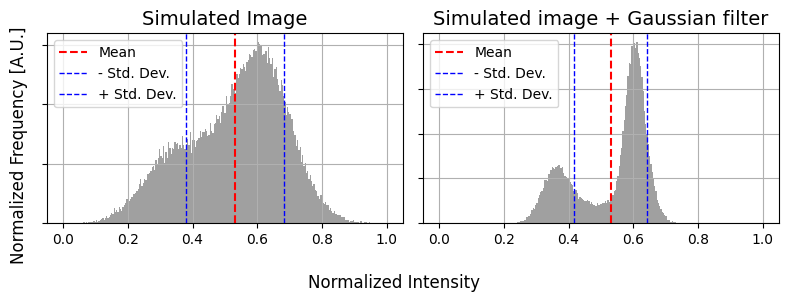

In [10]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Histogram for simulated image
axes[0].hist(flattened_image_simulated, bins=256, range=(0, 1), color='gray', alpha=0.75, density=True)
axes[0].axvline(mean_intensity_simulated, color='red', linestyle='dashed', linewidth=1.5, label="Mean")
axes[0].axvline(mean_intensity_simulated - std_intensity_simulated, color='blue', linestyle='dashed', linewidth=1, label="- Std. Dev.")
axes[0].axvline(mean_intensity_simulated + std_intensity_simulated, color='blue', linestyle='dashed', linewidth=1, label="+ Std. Dev.")
axes[0].set_title("Simulated Image", fontsize=14)
axes[0].set_yticklabels([])  # Remove y labels
axes[0].legend()
axes[0].grid(True)

# Histogram for filtered image
axes[1].hist(flattened_image_filtered, bins=256, range=(0, 1), color='gray', alpha=0.75)
axes[1].axvline(mean_intensity_filtered, color='red', linestyle='dashed', linewidth=1.5, label="Mean")
axes[1].axvline(mean_intensity_filtered - std_intensity_filtered, color='blue', linestyle='dashed', linewidth=1, label="- Std. Dev.")
axes[1].axvline(mean_intensity_filtered + std_intensity_filtered, color='blue', linestyle='dashed', linewidth=1, label="+ Std. Dev.")
axes[1].set_title("Simulated image + Gaussian filter", fontsize=14)
axes[1].set_yticklabels([])  # Remove y labels
axes[1].legend()
axes[1].grid(True)

# Set common x and y labels
fig.supxlabel("Normalized Intensity", fontsize=12)
fig.supylabel("Normalized Frequency [A.U.]", fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

We identify that there is an important contribution of intensities lower than the mean, which we capture by setting the threshold according to the empirical definition that we provide. Then we apply the threshold to calculate a mask and estimate the centroids to calculate the position of particles.

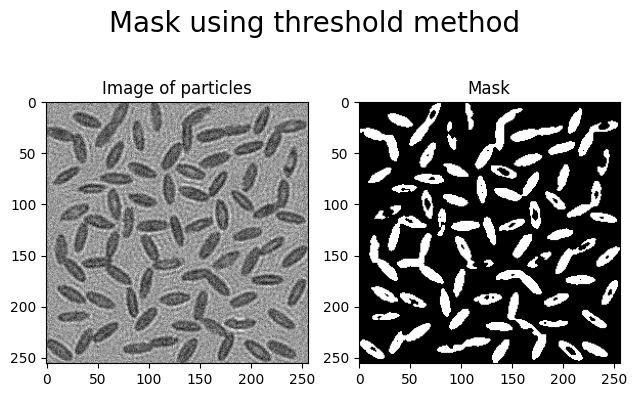

In [11]:
# Apply a Gaussian filter to the image to smooth out noise.
filtered_image_sim = scipy.ndimage.gaussian_filter(simulated_image, sigma=1.5)

# Create the binary mask by applying the threshold. 
threshold_mask = filtered_image_sim < threshold_intensity

# Ensure the mask is a 2D array.
threshold_mask = np.squeeze(threshold_mask)

# Plot the image with the calculated mask.
utils.plot_image_mask_ground_truth_map(
    image=simulated_image, 
    mask=threshold_mask, 
    title="Mask using threshold method",
)

### Determine the centroids from the mask using Scikit 

In [12]:
# Use the function to extract positions from mask.
detections_M1 = utils.mask_to_positions(threshold_mask)
print(f"Found {len(detections_M1[:,1])} detections.")


Found 67 detections.


### Plot the prediction of the centroids from mask

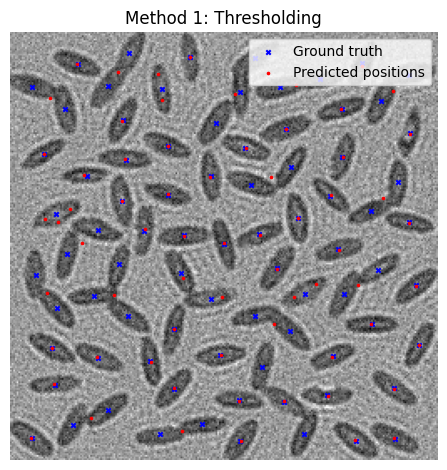

True Positives: 56/81
False Positives: 11
False Negatives: 25
F1 Score: 0.7568
RMSE: 1.4609


In [13]:
# Use the plotting function to compare the detection with the ground truth.
utils.plot_predicted_positions(image=simulated_image, 
                         predicted_positions=detections_M1, 
                         ground_truth_positions=gt_pos, 
                         title="Method 1: Thresholding"
)
utils.evaluate_locs(detections_M1, gt_pos, distance_th=particle_radius_px);

### Apply the function to evaluate performance the thresholding method
Evaluation metrics are printed: True Positives (TP), False Positives (FP), False Negatives (FN), F1 score (F!) and Mean Square Error (MSE).

In [14]:
# Evaluation metrics can be retrieved if returned outputs are asigned to a variable:
# TP, FP, FN, F1, RMSE = utils.evaluate_locs(detections_M1, gt_pos, distance_th=particle_radius)

utils.evaluate_locs(detections_M1, gt_pos, distance_th=particle_radius_px);

True Positives: 56/81
False Positives: 11
False Negatives: 25
F1 Score: 0.7568
RMSE: 1.4609


### Apply the threshold method to loaded experimental data
Here we apply a Gaussian blur filter before the threshold method, in order to \
improve the signal-to-noise ratio (SNR) and 

In [15]:
# Normalize the experimental image to have (0,1) intensity values
image = utils.normalize_min_max(image)

# Calculate the mean and standard deviation of the simulated image.
# Apply a Gaussian filter to the image to smooth out noise.
filtered_image_exp = scipy.ndimage.gaussian_filter(image, sigma=1.0)

# Flatten the images to 1D for histograms
flattened_image_filtered = filtered_image_exp.flatten()
# Flatten the images to 1D for histograms
flattened_image = image.flatten()

# Compute statistics for experimental image with and without Gaussian filter.
mean_intensity_filtered = np.mean(flattened_image_filtered)
std_intensity_filtered = np.std(flattened_image_filtered)

mean_intensity_exp = np.mean(flattened_image)
std_intensity_exp = np.std(flattened_image)

# We define the threshold in terms of mean intensity and standard deviation.
threshold_intensity_exp = mean_intensity_filtered - 1.0 * std_intensity_filtered

print(f"Intensity threshold: {threshold_intensity}")

Intensity threshold: 0.41675302929346447


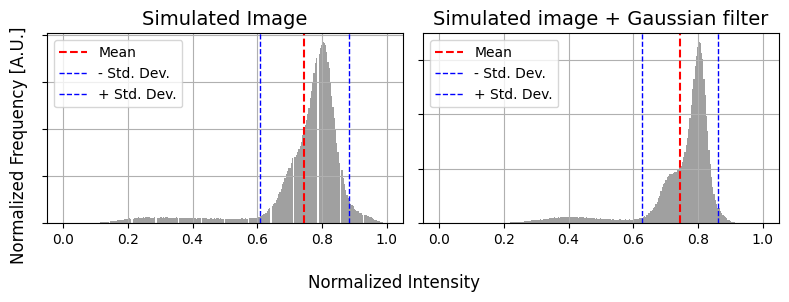

In [16]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Histogram for experimental image
axes[0].hist(flattened_image, bins=256, range=(0, 1), color='gray', alpha=0.75, density=True)
axes[0].axvline(mean_intensity_exp, color='red', linestyle='dashed', linewidth=1.5, label="Mean")
axes[0].axvline(mean_intensity_exp - std_intensity_exp, color='blue', linestyle='dashed', linewidth=1, label="- Std. Dev.")
axes[0].axvline(mean_intensity_exp + std_intensity_exp, color='blue', linestyle='dashed', linewidth=1, label="+ Std. Dev.")
axes[0].set_title("Simulated Image", fontsize=14)
axes[0].set_yticklabels([])  # Remove y labels
axes[0].legend()
axes[0].grid(True)

# Histogram for filtered image
axes[1].hist(flattened_image_filtered, bins=256, range=(0, 1), color='gray', alpha=0.75)
axes[1].axvline(mean_intensity_filtered, color='red', linestyle='dashed', linewidth=1.5, label="Mean")
axes[1].axvline(mean_intensity_filtered - std_intensity_filtered, color='blue', linestyle='dashed', linewidth=1, label="- Std. Dev.")
axes[1].axvline(mean_intensity_filtered + std_intensity_filtered, color='blue', linestyle='dashed', linewidth=1, label="+ Std. Dev.")
axes[1].set_title("Simulated image + Gaussian filter", fontsize=14)
axes[1].set_yticklabels([])  # Remove y labels
axes[1].legend()
axes[1].grid(True)

# Set common x and y labels
fig.supxlabel("Normalized Intensity", fontsize=12)
fig.supylabel("Normalized Frequency [A.U.]", fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

No ground truth positions were passed


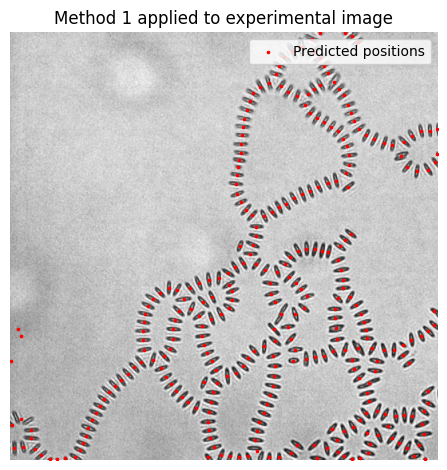

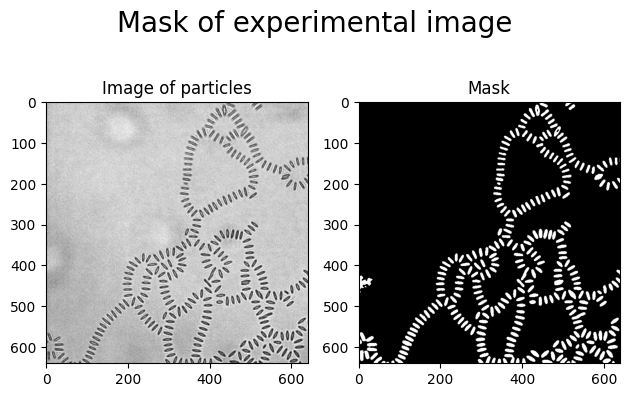

Found 302 detections.


In [17]:
# Apply Gaussian blur using SciPy library. This greatly improves detection 
# using threshold method.
filtered_image_exp = scipy.ndimage.gaussian_filter(image, sigma=2)

# Create the binary mask by applying the threshold.
mask_exp = filtered_image_exp < threshold_intensity_exp

# Get predicted positions from the mask
detections_M1_exp = utils.mask_to_positions(mask_exp)

# Plot the predictions overlaid on the experimental image
utils.plot_predicted_positions(
    image=image,
    predicted_positions=detections_M1_exp,
    title="Method 1 applied to experimental image",
    )

# Plot the experimental image and the mask
utils.plot_image_mask_ground_truth_map(
    image=image, 
    mask=mask_exp, 
    title="Mask of experimental image"
    )
# Print the number of detections.
print(f"Found {len(detections_M1_exp[:,1])} detections.")

## Method 2: Crocker and Grier (using Trackpy)
The Crocker and Grier method is a built-in function in Trackpy. The only user input parameter is the estimated diameter in pixel units, which in the ellipsoidal case must be passed as a tuple of odd integers.

#### Extract the semiaxes of an ellipsoid from the experimental image by clicking on the long and short semiaxes ends. 
Note that there is variability in particle size, so this measurement should be seen as an educated starting point, which is easily refined a posteriori.

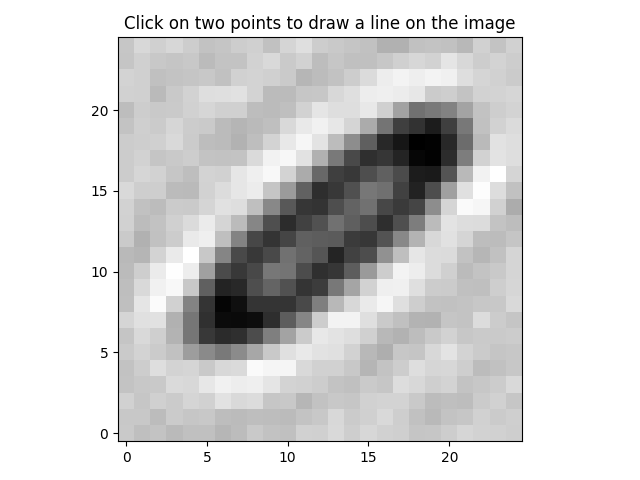

In [64]:
# Set the matplotlib interactive backend .
%matplotlib widget
utils.interactive_ruler(simulated_crop)

Semiaxes (in pixels) set by user : (13, 29)


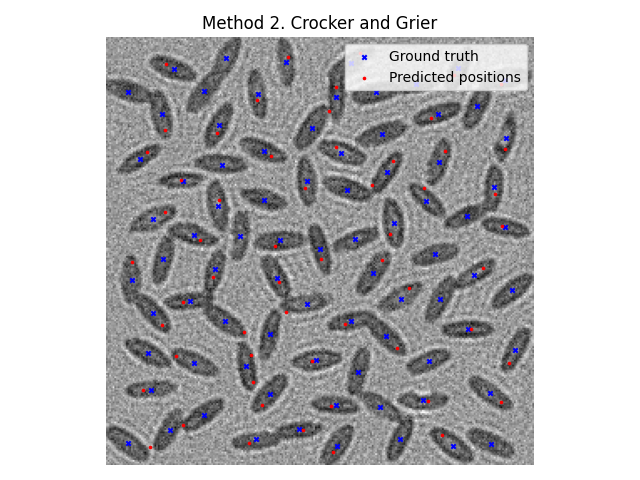

True Positives: 52/81
False Positives: 6
False Negatives: 29
F1 Score: 0.7482
RMSE: 2.4301


In [72]:
# Estimate the diameter of particles in pixels.
estimated_diameter = (13,29)
short_semiaxis = np.min(estimated_diameter)
print(f"Semiaxes (in pixels) set by user : {estimated_diameter}")

# Use the locate built-in function from TrackPy.
    # Output is type DataFrame([x, y, mass, size, ecc, signal, raw_mass])
localizations_dataframe = tp.locate(
    simulated_image, 
    diameter=estimated_diameter, 
    invert=True,
    preprocess=True,
    smoothing_size=(9)
    )

# Extract the predicted positions from DataFrame["x","y"] into a NumPy array.
detections_M2 = np.array(localizations_dataframe)[:,:2]

# Plot the prediction and the ground truth.
utils.plot_predicted_positions(image=simulated_image,
                         predicted_positions=detections_M2,
                         ground_truth_positions=gt_pos,
                         title="Method 2. Crocker and Grier"
)

# Evaluate the performance of tp.locate
utils.evaluate_locs(detections_M2, gt_pos, distance_th=short_semiaxis);

### 

## Apply to experimental image

Extract the semiaxes from experimental crop in interactive mode.

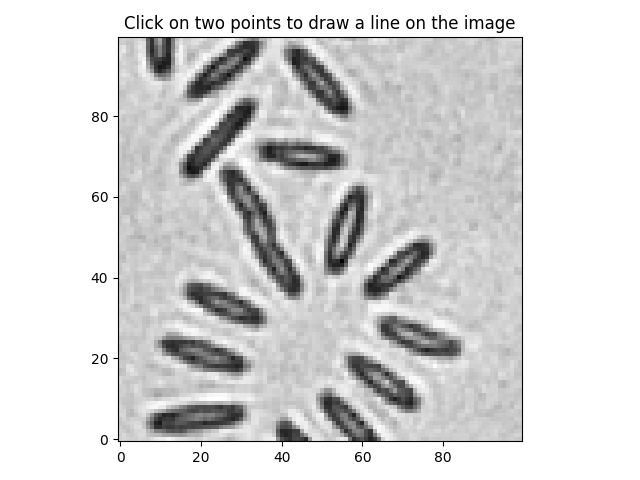

In [ ]:
# Plot a small section of the experimental image.
utils.interactive_ruler(image[370:470, 370:470])

Apply the Crocker and Grier method to the experimental image with the extracted semiaxes.

No ground truth positions were passed


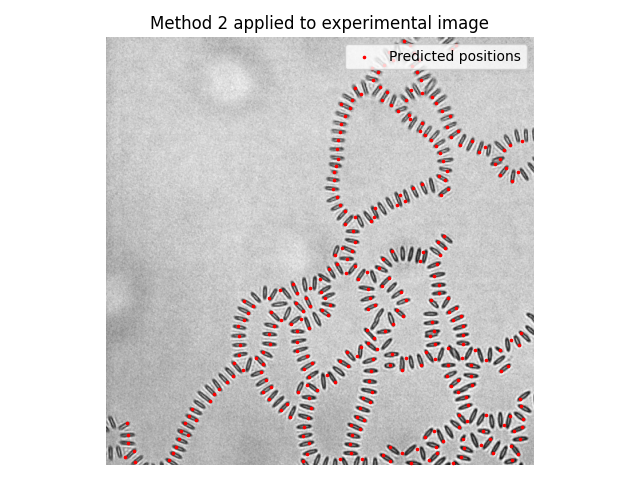

Found 307 detections.


In [124]:
# Semiaxes of experimental crop. Tuned to improve detections.
semiaxes_exp = (5,27)

# Use Trackpy.locate to the pre-filtered experimental image.
localizations_dataframe_exp = tp.locate(
    filtered_image_exp, 
    diameter=semiaxes_exp, 
    invert=True,
    preprocess=True,
    smoothing_size=(7),
    )
# Extract the predicted positions from DataFrame["x","y"] into a NumPy array.
detections_M2_exp = np.array(localizations_dataframe_exp)[:,:2]

# Plot the experimental image with predicted positions overlaid.
utils.plot_predicted_positions(image=image,
                         predicted_positions=detections_M2_exp,
                         title="Method 2 applied to experimental image"
                         )

# Print the number of detections
num_detections = len(detections_M2_exp[:,1])
print(f"Found {num_detections} detections.")

## Method 3: UNet

U-Net is a convolutional neural network (CNN), a type of deep learning model, commonly used for image segmentation tasks. It assigns a class label to each pixel in an image, allowing for precise differentiation between the background and objects of interest, from particles to complex cells or anatomical structures, depending on the training. The name "U-Net" comes from its U-shaped architecture, where the encoder (downsampling path) and decoder (upsampling path) are symmetric. The network's bottleneck, located at the center of the U, captures high-level features at reduced spatial resolution, while skip connections preserve fine-grained spatial details.

### Create a training dataset
Simulated images of particles are generated using DeepTrack, along with their corresponding ground truth maps, which serve as the ground truth.

Load a dataset if available, otherwise, generate it according to the size of the sample and the image size defined by the user

In [ ]:
# Number of samples, image size, and particles.
num_samples = 256
image_size = 64
max_num_particles = 10
force_simulation = False  # Flag to force simulation even if data exists.

# Set the optical properties of the microscope.
optics_properties = dt.Darkfield(
    NA=1.33,  # Numerical aperture
    wavelength=638.0 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=2,
    resolution=200 * dt.units.nm,  # Camera resolution or effective resolution.
    )

# Create path to store training dataset.
folder_name = "UNet"
training_dataset_filename = "UNet_training_dataset_ellipsoids.npz"
training_dataset_folder = folder_name + "/" + "training_data"
training_dataset_filepath = (
    training_dataset_folder + "/" + training_dataset_filename
    )

# Create the enclosing directory if not existent already.
if not os.path.exists(training_dataset_folder):
    os.makedirs(training_dataset_folder, exist_ok=True)

# Try to load preexisting simulated data; if not available or forced, generate 
# new data.
try:
    if force_simulation: 
        # Raise the exception error if simulation is forced.
        raise FileNotFoundError("Forced simulation by user request.")
    
    if not os.path.isfile(training_dataset_filepath):
        # If file is not found, start training.    
        raise FileNotFoundError("Training dataset file not found. Starting simulation.")
    
    # Load existing data
    data = np.load(training_dataset_filepath)
    print(f"Loaded file: {training_dataset_filepath}")
    images = data['images']
    maps = data['maps']
    Nsamples = len(images)
        
# Handle the case of either file not found or forced training.
except FileNotFoundError:
    
    # Perform simulation if file not found or forced.
    images, maps = utils.generate_particle_dataset(
        num_samples,
        image_size,
        max_num_particles,
        core_particle_properties, # We use the same dicitionaries as before.
        shell_particle_properties,
        optics_properties=optics_properties
        )
    
    # Save the simulated training dataset.
    np.savez(training_dataset_filepath, images=images, maps=maps)
    print(f"Training dataset saved in: {training_dataset_filepath}.")

Check dimensions of training data. The format to train a U-Net model with Deeplay should be (N,X,Y,C), where:\
\
N: Number of samples (simulated images).\
X: Intensity in the X position.\
Y: Intensity in the Y position.\
C: Color channel (1 for grayscale).

In [ ]:
print(f"Image dimensions: {images.shape}")
print(f"Maps dimensions: {maps.shape}")

### Visualize the simulated training dataset


In [ ]:
# Select an image and its corresponding ground truth maps and mask to show.
selected_image_index = np.random.randint(0, len(images))

# Extract the image and ground truth map from 4D arrays.
selected_image = np.squeeze(images[selected_image_index])
selected_ground_truth_map = np.squeeze(maps[selected_image_index])

print(f"Size of image: {selected_image.shape}")
print(f"Size of gr map: {selected_ground_truth_map.shape}")

# Plot a randomly chosen element pair from the training dataset.
utils.plot_image_mask_ground_truth_map(
    image=selected_image,
    ground_truth_map=selected_ground_truth_map,
    title=f"Training dataset element: {selected_image_index + 1}/{len(images)}"
    )

## Define a U-Net model using Deeplay
The input and output channels of the 2D U-Net are equal to 1, since for the moment we are only analyzing a single color channel corresponding to light intensity in grayscale. We want the U-Net model to be able to predict a ground truth map of particles from an experimental image. The single-channel output will then be this spatial probability density, in which each local maxima is located precisely at the particle center.

The U-Net architecture need to be deep enough in order to have a good (reduced) representation of the input image. In order to set the number of convolutional layers N, we use the heuristic argument that N layers, provided with a (default) kernel size of 3x3, enables a (3x3)^N window to look for features in an image. Three layers will enable a 27x27 window, suitable to train a detector of particles with diameters up to 27 pixel units.

In [ ]:
# Input and output channels are set to 1, since both images and probability
# maps only have one color channel.
unet = dl.UNet2d(
    in_channels=1, 
    channels=[16, 32, 64, 128], 
    out_channels=1,
    )

# print(unet)

### Compile the model for the task of regressing the ground truth map from an image

In [ ]:
# A U-Net regressor is defined using a deeplay model. The loss function is Mean
# Squared Error Loss, since the output is a continuous intensity map.
unet_reg = dl.Regressor(
    model=unet, 
    loss=torch.nn.MSELoss(), 
    optimizer=dl.Adam(lr=1e-3)
    ).create()

# print(unet_reg)

### Define the training pipeline using Deeptrack to generate the training dataset
The training pipeline is composed of the simulated images and the ground truth maps, together with instructions of value normalization and a selector of images, all of which are instances of Deeplay. Some augmentations, such as the addition of Gaussian noise, can be added to the training pipeline in order to introduce even more variation to the training dataset.

In [ ]:
# Image selector with a random picker. This is performed in order to properly 
# link an element in maps array with its corresponding element in images 
# array.
selector = dt.Lambda(
    lambda i: lambda x: x[i], i=lambda l: np.random.randint(l), l=len(images)
    )

# Apply augmentations of added Gaussian noise only to images.
images_augmentations = (
    dt.Value(images)
    #>> dt.Gaussian(0.0, 0.1)
    >> dt.NormalizeMinMax(0.0, 1.0)
    )

# Apply normalization to ground truth map.
maps = dt.Value(maps) >> dt.NormalizeMinMax(0.0, 1.0)

# Training pipeline with instructions
pipeline = (images_augmentations & maps) >> selector

# Create the training dataset instance in PyTorch
train_dataset = dt.pytorch.Dataset(pipeline, length=256)

Check one augmented crop at random

In [ ]:
# Sanity check
sanity_check_pipeline_augmentation = np.squeeze(pipeline.update().resolve())
sanity_check_image_augmentation = sanity_check_pipeline_augmentation[0]
sanity_check_map_augmentation = sanity_check_pipeline_augmentation[1]

# # Plot the image as the first subplot
utils.plot_image_mask_ground_truth_map(
    image=sanity_check_image_augmentation,
    ground_truth_map=sanity_check_map_augmentation,
    title=f"Random augmentation from training pipeline",
    )

### Train the U-Net model

In [ ]:
from torch.utils.data import DataLoader

# Create a DataLoader for training.
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True,
    )

# Initialize UNet trainer with automatic accelerator (e.g., CUDA if available).
unet_trainer = dl.Trainer(max_epochs=128, accelerator="auto")

Tries to load weights if existent. Else, start training.

In [ ]:
# Force training if desired.
force_training = False

# Define the file paths for the model weights.
unet_path = "UNet_model_ellipsoids.pth"
unet_reg_path = "UNet_reg_ellipsoids.pth"

# Define the name of an enclosing folder and add it to the file path.
folder_name = "UNet"
unet_path =  folder_name + "/" + unet_path
unet_reg_path = folder_name + "/" + unet_reg_path

# Check if trained is not forced and both weight files exist in order to load 
# them.
if not force_training and os.path.exists(unet_path) and os.path.exists(unet_reg_path):
    # Load the dictionaries
    unet.load_state_dict(torch.load(unet_path, weights_only=True))
    unet_reg.load_state_dict(torch.load(unet_reg_path, weights_only=True))
    print("Loaded preexisting UNet weights.")

# Starts training if forced or if unet weights are not found in the path.
if force_training or not os.path.exists(unet_path):
    # Create the enclosing directory if not existent already.
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    
    # Start training with the regressor and the data loader.
    unet_trainer.fit(unet_reg, train_loader)
    
    # Save the pre-trained weights of the U-Net model as Python dictionaries.
    torch.save(unet.state_dict(), unet_path)
    torch.save(unet_reg.state_dict(), unet_reg_path)
    print(f"U-Net weights saved in {unet_reg_path}.")


### Apply the trained U-Net to the simulated image
Select a new image that has not been used for the training to infere the ground truth map, based on the learning acquired by the U-Net.

In [ ]:
# Select an image to apply the learning by the U-Net.
image_of_particles = simulated_image

# Normalize intensity of image to (0,1).
image_of_particles = utils.normalize_min_max(image_of_particles)

# Check the image array shape.
print(f" Shape of selected image: {image_of_particles.shape} ")

# Reshape the array to match the (N, C, X, Y) format.
missing_array_dimensions = 4 - len(image_of_particles.shape)
for missing_dims in range(missing_array_dimensions):
    image_of_particles = np.expand_dims(image_of_particles, axis=0)
    print(f" Shape of selected image after reshaping to match the (N, C, X, Y): {image_of_particles.shape} ")

# Transpose PyTorch array (done to make the simulated image compatible with PyTorch indexing).
if image_of_particles.shape[-1] == 1: # If last element is color channel.
    image_of_particles = image_of_particles.transpose(0, 3, 1, 2)
    print(f" Shape of selected image after transposing to match the (N, C, X, Y): {image_of_particles.shape} ")

Convert the selected image to a PyTorch tensor to infer the ground truth map of the particles using the learning of the trained U-Net

In [ ]:
# Ensure that the image is a numpy array in float32 format.
image_of_particles_array = np.array(image_of_particles).astype(np.float32)

# Convert the image to analyze into a PyTorch tensor.
image_of_particles_tensor = torch.from_numpy(image_of_particles_array)

# Apply the UNet to the loaded image.
pred_maps_tensor = unet_reg(image_of_particles_tensor)

# Convert to NumPy array.
pred_maps_array = pred_maps_tensor[0,0,:,:].detach().numpy()
image_of_particles = image_of_particles_array[0,0,:,:]

# Normalize intensity.
pred_maps_array = utils.normalize_min_max(pred_maps_array)

Apply the mask method to the predicted ground truth map

In [ ]:
# Apply thresholding to the predicted ground truth map.
pred_mask_unet = pred_maps_array > 0.25

# Convert the masked ground truth map to positions.
detections_unet = utils.mask_to_positions(pred_mask_unet)

# Show the predicted posiions overlaid with the ground truth on the simulated
# image.
utils.plot_predicted_positions(image=image_of_particles_array,
                         predicted_positions=detections_unet, 
                         ground_truth_positions=gt_pos,
                         title="Prediction from U-Net"
                         )

# Measure the performance.
utils.evaluate_locs(detections_unet, gt_pos, distance_th=particle_radius_px)

#Plot the predicted ground truth map and its masked version.
utils.plot_image_mask_ground_truth_map(
    mask=pred_mask_unet,
    ground_truth_map=pred_maps_array,
    title="U-Net prediction on simulated data"
)

### Apply the trained U-Net to the experimental image


In [ ]:
# Normalize intensity of image to (0,1).
image_of_particles_exp = utils.normalize_min_max(image)

# Reshape the array to match the (N, C, X, Y) format.
image_of_particles_exp = image_of_particles_exp[np.newaxis, np.newaxis, ...]

# Ensure that the image is a numpy array.
image_of_particles_exp = np.array(image_of_particles_exp).astype(np.float32) 

# Convert the image to analyze into a PyTorch tensor.
image_of_particles_exp_tensor = torch.from_numpy(image_of_particles_exp)

# Apply the UNet to the loaded image.
pred_maps_unet_exp = unet_reg(image_of_particles_exp_tensor)

# Convert the prediction to a NumPy array for easy plotting.
pred_maps_unet_exp_array = pred_maps_unet_exp[0, 0, :, :].detach().numpy()

# Normalize intensity to (0,1).
pred_maps_unet_exp_array = utils.normalize_min_max(pred_maps_unet_exp_array)

# Calculate a mask from the ground truth map with thresholding method.
pred_mask_unet_exp = pred_maps_unet_exp_array > 0.2

# Extract the positions from the mask.
detections_unet_exp = utils.mask_to_positions(pred_mask_unet_exp)

# Plot the experimental image with the positions predicted by U-Net.
utils.plot_predicted_positions(image=image, 
                         predicted_positions=detections_unet_exp,
                         title="Positions predicted by U-Net. Experimental image",
                         )

#Plot the predicted ground truth map and its masked version.
utils.plot_image_mask_ground_truth_map(
    mask=pred_mask_unet_exp,
    ground_truth_map=pred_maps_unet_exp_array,
    title="U-Net prediction on experimental image",
    )

## Method 4: LodeSTAR
LodeSTAR is a self-supervised object detection method that can be trained using a single input image. Here we offer methods to train LodeSTAR with simulated and experimental data.

LodeSTAR must be fed with crops of the objects of interest. For this, we use DeepTrack to simulate a handful of images containing one single particle with a certain degree of variation in their sizes and intensities to enhance the richness of the training dataset.

We start by simulating the data, provided with a set of parameters that we can adjust to mimic experimental images. Note that we will simulate images of individual particles, thus, the parameters are different since there is no interference patterns with signals of adyacent particles.

In [ ]:
# Number of samples, image size, and particles.
num_samples = 128
image_size = 40
max_num_particles = 1
force_simulation = False  # Flag to force simulation even if data exists.

# Create path to store training dataset.
folder_name = "LodeSTAR"
training_dataset_filename = "LodeSTAR_training_dataset_ellipsoids.npz"
training_dataset_folder = folder_name + "/" + "training_data"
training_dataset_filepath = (
    training_dataset_folder + "/" + training_dataset_filename
    )

# Create the enclosing directory if not existent already.
if not os.path.exists(training_dataset_folder):
    os.makedirs(training_dataset_folder, exist_ok=True)

# Dictionaries for shell and core properties. Dimensions are set with lambda
# functions to introduce a bounded level of randomness to the dataset. 
core_particle_properties = {
    "radius": lambda: np.random.uniform(0.75, 1.3)
    * dt.units.nm
    * (axis_length, np.random.uniform(0.7, 1.1) * eccentricity * axis_length),
    "intensity": lambda: 600 * np.random.uniform(0.75, 1.25),
}

shell_particle_properties = {
    "radius": lambda: 1.5 * np.random.uniform(1.0, 1.2)
    * dt.units.nm
    * (
        axis_length, 
        np.random.uniform(0.9, 1.1) * eccentricity * axis_length
        ),
    "intensity": lambda: -400 * np.random.uniform(0.75, 1.4)
    }


core_particle_properties = {
    "radius": lambda: dt.units.nm
    * np.random.uniform(1.0, 1.25)
    * (axis_length, np.random.uniform(0.95, 1.05) * eccentricity * axis_length),
    "intensity": 1200, 
    }

shell_particle_properties = {
    "radius": lambda: 1.75
    * dt.units.nm
    * (
        np.random.uniform(0.95, 1.05) * axis_length,
        np.random.uniform(0.9, 1.15) * eccentricity * axis_length,
    ),
    "intensity": -50, 
    }

# Set the optical properties of the microscope.
optics_properties = dt.Darkfield(
    NA=1.33,  # Numerical aperture
    wavelength=638.0 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=2,
    resolution=200 * dt.units.nm,  # Camera resolution or effective resolution.
    )

# Try to load preexisting simulated data; if not available or forced, raise the
# exception error to generate new data.
try:
    if force_simulation: 
        # Raise the exception error if simulation is forced.
        raise FileNotFoundError("Forced simulation by user request.")
    
    if not os.path.isfile(training_dataset_filepath):
        # If file is not found, start training.    
        raise FileNotFoundError("Training dataset file not found. Starting simulation.")
    
    # Load existing data
    data = np.load(training_dataset_filepath)
    crop_images = data["crop_images"]
    crop_maps = data["crop_maps"]
    Nsamples = len(crop_images)  # Update number of samples.
    print(f"Loaded file: {training_dataset_filepath}")
        
# Handle the case of either file not found or forced training.
except FileNotFoundError:
    
    # Perform simulation if file not found or forced.
    crop_images, crop_maps = utils.generate_particle_dataset(
        num_samples,
        image_size,
        max_num_particles,
        core_particle_properties,
        shell_particle_properties,
        optics_properties
        )

    # Save the simulated training dataset.
    np.savez(
        training_dataset_filepath, 
        crop_images=crop_images, 
        crop_maps=crop_maps
        )
    print("Generated and saved new dataset.")
    
    # Plot up to 18 simulated crops.
utils.plot_crops(np.squeeze(crop_images), title="Simulated crops")

Define a training pipeline with Deeptrack and PyTorch.

In [ ]:
# Define the training pipeline with additional settings, such as multiplication
# of global intensity and Gaussian noise.
selector = dt.Lambda(
    lambda i: lambda x: x[i], i=lambda l: np.random.randint(l), l=len(crop_images)
    )

training_pipeline = (
    dt.Value(crop_images)
    >> dt.Gaussian(0, 0.1)
    >> dt.NormalizeMinMax(0.05, 0.95)
    >> selector
    )

# Build a training dataset with a pipeline that randomly selects a crop each
# time.
train_dataset = dt.pytorch.Dataset(
    training_pipeline,
    length=256,
    )

# Dataloader contains the randomized training dataset and additional settings.
dataloader = dl.DataLoader(
    train_dataset,
    batch_size=8,
    )

# We can check one of the elements in the training pipeline with augmentations.
sanity_check_crop = training_pipeline.update().resolve()
plt.imshow(np.squeeze(sanity_check_crop), cmap="gray")
plt.title("Random crop from training pipeline")
plt.axis("off")
plt.show()

### Initiate the LodeSTAR model and the trainer

In [ ]:
#  Initialize the model.
lodestar = dl.LodeSTAR(
    n_transforms=4, 
    optimizer=dl.Adam(lr=1e-3) 
    ).build()

# Set up the trainer and specify number of epochs.
trainer_lodestar = dl.Trainer(max_epochs=48)

### Load pre-trained weights or generate new weights.
To save time, if you have already run the training you can load pre-existing weights.

In [ ]:
force_training = True

# File name of pre-trained weights.
lodestar_path = "lodestar_weights_simulated"

# Define the name of an enclosing folder and add it to the file path.
folder_name = "LodeSTAR"
lodestar_path =  folder_name + "/" + lodestar_path

#  Check if weights exist or if training will be forced.
if not os.path.isfile(lodestar_path) or force_training:
    
    # Create the enclosing directory if not existent already.
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    
    #  Start training.
    trainer_lodestar.fit(lodestar, dataloader)
    torch.save(lodestar.state_dict(),lodestar_path)
else:
    
    #  Load pre-existing weights.
    lodestar.load_state_dict(
        torch.load(
            lodestar_path,
            weights_only=True,
            )
        )
    print("Loaded preexisting LodeSTAR weights trained on simulated data.")

# Switch the model to evaluation mode.
lodestar.eval();

With the training complete, we are now ready to benchmark the performance by predicting the positions on simulated data, where the ground truth is known.

In [ ]:
#  Parameters for inference.
alpha = 0.4
beta = 1 - alpha
cutoff = 0.01

#  Extract predictions.
prediction = lodestar(image_of_particles_tensor).squeeze().detach()

# Extract the mass feature from the prediction.
mass_feature = prediction[2]

# Infer on the pytorch-tensor-type image.
detections_lodestar = lodestar.detect(image_of_particles_tensor,
                         alpha = alpha,
                         beta = beta, 
                         mode = "constant",
                         cutoff = cutoff
                         )[0]
                         
print(f"Found {len(detections_lodestar[:,1])} detections.")

### Display predictions from the simulated image

In [ ]:
plt.figure(figsize=(10, 5))

#  Subfigure 1, simulated image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(simulated_image), cmap="gray")
plt.axis("off")
plt.title("Simulated image")

#  Subfigure 2, probability distribution.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature, cmap="gray")
plt.axis("off")
plt.title("Mass features predicted by LodeSTAR")

plt.axis("off")
plt.tight_layout()
plt.show()

### Overlay detections to simulated image
Measure the detection accuracy by contrasting with the ground truth of positions.

In [ ]:
# Plot the predicted positions and the ground truth overlaid on the simulated
# image.
utils.plot_predicted_positions(image=simulated_image,
                               predicted_positions=detections_lodestar,
                               ground_truth_positions=gt_pos,
                               title="Method 4: LodeSTAR on simulated image"
                               )
#  Evaluate performance.
utils.evaluate_locs(detections_lodestar, gt_pos, distance_th=particle_radius_px);

We can apply LodeSTAR trained on simulated data to the experimental image

In [ ]:
#  Parameters for inference.
alpha = 0.5
beta = 1 - alpha
cutoff = 0.00001

#  Extract predictions and convert into a tensor.
prediction_exp = lodestar(image_of_particles_exp_tensor).squeeze().detach()

# Extract the mass feature from the prediction.
mass_feature_exp = prediction_exp[2]

#  Infer positions from experimental image.
detections_lodestar_experimental = lodestar.detect(image_of_particles_exp_tensor,
                         alpha = alpha,
                         beta = beta, 
                         mode = "constant",
                         cutoff = cutoff
                         )[0]
                         
print(f"Found {len(detections_lodestar_experimental[:,1])} detections.")
### Display predictions of experimental image.
# Set the figure size.
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(image_of_particles_exp), cmap="gray")
plt.axis("off")
plt.title("Experimental image")

#  Subfigure 2, probability distribution.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature_exp, cmap="gray")
plt.axis("off")
plt.title("Mass features predicted by LodeSTAR")

plt.gca().set_aspect('equal', adjustable='box')
plt.axis("off")
plt.tight_layout()
plt.show()

Overlay the predicted positions on the experimental image

In [ ]:
utils.plot_predicted_positions(
   image=image_of_particles_exp[0,0,:,:],
   predicted_positions= detections_lodestar_experimental,
   title="Method 4: LodeSTAR on experimental image"
)

### Training using experimental crops instead of simulated data.
Since LodeSTAR is a self-supervised neural network, we can train it with experimental crops instead of simulations. By analyzing the image, we extract the coordinate pairs corresponding to characteristic particles.

Initiate the training pipeline with experimental crops

In [ ]:
# Get coordinates from relevant crop samples.
xs = [488, 447, 480, 431, 190, 525, 567]
ys = [385, 408, 413, 476, 582, 615, 15]

number_of_crops = len(xs)

# Pre-allocate array to store all the crops.
training_images = []
for i in range(number_of_crops):
    # Go through the locations of the crops in the image.
    y_index   = ys[i]
    x_index   = xs[i]
    crop_size = 23

    # Crop a window in the image.
    x0 = x_index
    y0 = y_index
    training_image = np.array(
        image[
            x0:x0 + crop_size, 
            y0: y0 + crop_size
            ]
        )

    # Expand dims with np.newaxis and append to list.
    training_images.append(training_image[np.newaxis, ...])

# Plot up to 18 simulated crops.
utils.plot_crops(np.squeeze(training_images), title="Experimental crops")


Prepare the training pipeline with the selected experimental crops

In [ ]:
# Random selector of crops.
random_crop = lambda: random.choice(training_images)

# Define training pipeline.
training_pipeline = (
    dt.Value(random_crop)
    >> dt.Gaussian(0.0,0.05)
    >> dt.NormalizeMinMax(0.0, 1.0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
    )

# Build a training dataset with a pipeline that randomly selects a crop each
# time.
train_dataset = dt.pytorch.Dataset(
    training_pipeline,
    length=512,
    )

# Dataloader contains the randomized training dataset and additional settings.
dataloader = dl.DataLoader(
    train_dataset,
    batch_size=16,
    )

# We can check one of the elements in the training pipeline with augmentations.
sanity_check_crop = training_pipeline.update()()
plt.imshow(np.squeeze(sanity_check_crop), cmap="gray")
plt.title("Random crop from training pipeline")
plt.axis("off")
plt.show()

### Initiate the LodeSTAR model and the trainer

In [ ]:
#  Initialize the model as a Deeplay instance.
lodestar_exp = dl.LodeSTAR(
    n_transforms=8, 
    optimizer=dl.Adam(lr=1e-3)
    ).build()

# Initialize the trainer.
trainer_lodestar_exp = dl.Trainer(max_epochs=50)

#print(model)

### Load pre-trained weights or generate new weights.
To save time, if you have already run the training you can load pre-existing weights.

In [ ]:
force_training = False

# File name of pre-trained weights.
lodestar_exp_path = "lodestar_weights_exp"

# Define the name of an enclosing folder and add it to the file path.
folder_name = "LodeSTAR"
lodestar_exp_path =  folder_name + "/" + lodestar_exp_path

#  Check if weights exist.
if not os.path.isfile(lodestar_exp_path) or force_training:
    
    # Create the enclosing directory if not existent already.
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

    #  Start training.
    trainer_lodestar_exp.fit(lodestar_exp, dataloader)
    torch.save(lodestar_exp.state_dict(), lodestar_exp_path)
else:
    #  Load pre-existing weights.
    lodestar_exp.load_state_dict(
        torch.load(
            lodestar_exp_path,
            weights_only=True
            )
        )
    print("Loaded preexisting LodeSTAR weights trained on experimental data")

# Switch the model to evaluation mode.
lodestar_exp.eval();

### Predict positions on experimental image

In [ ]:
#  Parameters for inference.
alpha = 0.1
beta = 1 - alpha 
cutoff = 0.01
#  Extract predictions and convert into a tensor.
prediction_exp = lodestar_exp(image_of_particles_exp_tensor).squeeze().detach()

# Extract the mass feature from the prediction.
mass_feature_exp = prediction_exp[2]

#  Infer positions from experimental image.
detections_lodestar_experimental = lodestar_exp.detect(image_of_particles_exp_tensor,
                         alpha=alpha,
                         beta=beta, 
                         mode="constant",
                         cutoff=cutoff
                         )[0]
                         
print(f"Found {len(detections_lodestar_experimental[:,1])} detections.")

### Display predictions of experimental image

In [ ]:
# Set the figure size.
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(image_of_particles_exp), cmap="gray")
plt.axis("off")
plt.title("Experimental image")

#  Subfigure 2, mass feature distribution.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature_exp, cmap="gray")
plt.axis("off")
plt.title("Mass features predicted by LodeSTAR")

plt.gca().set_aspect('equal', adjustable='box')
plt.axis("off")
plt.tight_layout()
plt.show()

Overlay the predicted positions on the experimental image

In [ ]:
utils.plot_predicted_positions(
   image=image_of_particles_exp[0,0,:,:],
   predicted_positions= detections_lodestar_experimental,
   title="Method 4: LodeSTAR on experimental image"
)